In [1]:
import warnings
warnings.filterwarnings('ignore')

from TGA.utils import Dataset

from tqdm.notebook import tqdm
from TGA.utils import preprocessor
import copy

from time import time
import numpy as np
from itertools import repeat
from collections import Counter
from segtok import tokenizer as tk

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
import matplotlib.pyplot as plt

In [3]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
dataset = Dataset('/home/datasets/acm/')
fold = next(dataset.get_fold_instances(10, with_val=True))
fold._fields, len(fold.X_train)

(('X_train', 'y_train', 'X_test', 'y_test', 'X_val', 'y_val'), 19907)

In [6]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [7]:
from nltk.stem import PorterStemmer 
ps = PorterStemmer()

class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, mindf=2, stopwords='remove', model='list', lan='english', k=25, verbose=False):
        super(Tokenizer, self).__init__()
        self.mindf = mindf
        self.le = LabelEncoder()
        self.verbose = verbose
        self.stopwords = stopwords
        self.stopwordsSet = stop_words
        self.lan = lan
        self.k = k
        self.model = model
        self.analyzer = TfidfVectorizer(preprocessor=preprocessor, min_df=mindf)#.build_analyzer()
        local_analyzer  = self.analyzer.build_analyzer()
        self.analyzer.set_params( analyzer=local_analyzer )
        #self.analyzer.set_params( analyzer=lambda x: map(ps.stem, local_analyzer(x)) )
        #self.analyzer = tk.web_tokenizer
    
    def fit(self, X, y):
        self.N = len(X)
        y = self.le.fit_transform( y )
        self.n_class = len(self.le.classes_)
        

        self.term_freqs = Counter()
        local_analyzer = self._get_analyzer_()
        docs = map(local_analyzer, X)
        for doc_in_terms in tqdm(docs, total=self.N, disable=not self.verbose):
            doc_in_terms = list(map( self._filter_fit_, doc_in_terms ))
            self.term_freqs.update(list(set(doc_in_terms)))
        self.node_mapper      = {'<BLANK>': 0}
        self.term_freqs       = { term:v for (term,v) in self.term_freqs.items() if v >= self.mindf }    
        self.node_mapper      = { term:self._get_idx_(term) for term in self.term_freqs.keys() if self._isrel_(term) }
        self.node_mapper['<UNK>'] = len(self.node_mapper)
        self.node_mapper['<BLANK>'] = 0
        self.vocab_size = len(self.node_mapper)
        
        if self.model == 'topk' or self.model == 'sample':
            from multiprocessing import cpu_count
            from sklearn.ensemble import RandomForestClassifier
            
            self.rf = RandomForestClassifier(n_jobs=cpu_count(), verbose=self.verbose>0)
            self.rf.fit(self.analyzer.fit_transform(X), y)
            imps = self.rf.feature_importances_
            self.fi_ = { term: imps[idterm] for (term, idterm) in self.analyzer.vocabulary_.items() }
            self.fi_['<BLANK>'] = 0.
            self.fi_['<UNK>'] = 0.
            for term in self.node_mapper.keys():
                if term not in self.fi_:
                    print(term)
            
        return self
    def _isrel_(self, term):
        if self.stopwords == 'remove' and term in self.stopwordsSet:
            return False
        # put here your filter_functions
        return True
    def _get_idx_(self, term):
        # put here your idx_set_functions
        if self.stopwords == 'mark' and term in self.stopwordsSet:
            return self.node_mapper.setdefault('<STPW>', len(self.node_mapper))
        return self.node_mapper.setdefault(term, len(self.node_mapper))
    def _filter_transform_(self, term):
        if self.stopwords == 'mark' and term in self.stopwordsSet:
            return '<STPW>'
        if term not in self.node_mapper:
            return '<UNK>'
        return term
    def _filter_fit_(self, term):
        if self.stopwords == 'mark' and term in self.stopwordsSet:
            return '<STPW>'
        return term
    def _model_(self, doc):
        doc = map( self._filter_transform_, doc )
        if self.model == 'set':
            return set(doc)
        if self.model == 'topk':
            doc = list(set(doc))
            doc = np.array(doc)
            weigths = np.array([ self.fi_[t] for t in doc ])
            doc = doc[(-weigths).argsort()[:self.k]]
            return doc
        if self.model == 'sample':
            doc = list(set(doc))
            if len(doc) > self.k:
                doc = np.array(doc)
                weigths = np.array([ self.fi_[t] for t in doc ])
                weigths = softmax(weigths)
                doc = np.random.choice(doc, size=self.k, replace=False, p=weigths)
            return doc
        return list(doc)
    def transform(self, X, verbose=None):
        verbose = verbose if verbose is not None else self.verbose
        n = len(X)
        doc_off = [0]
        terms_idx = []
        local_analyzer = self._get_analyzer_()
        for i,doc_in_terms in tqdm(enumerate(map(local_analyzer, X)), total=n, disable=not verbose):
            doc_in_terms = filter( self._isrel_, doc_in_terms )
            doc_in_terms = map( self._filter_transform_, doc_in_terms )
            doc_in_terms = self._model_(doc_in_terms)
            doc_in_terms = [ self.node_mapper[tid] for tid in doc_in_terms ]
            if self.model == 'sorted':
                doc_in_terms = sorted(doc_in_terms)
            doc_off.append( len(doc_in_terms) )
            terms_idx.extend( doc_in_terms )
        return np.array( terms_idx ), np.array(doc_off)[:-1].cumsum()
    def _get_analyzer_(self):
        return self.analyzer.analyzer

In [56]:
tokenizer = Tokenizer(mindf=1, stopwords='keep', model='sample', k=128, verbose=True)
tokenizer.fit(fold.X_train, fold.y_train)

  0%|          | 0/19907 [00:00<?, ?it/s]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    9.6s finished


Tokenizer(k=128, mindf=1, model='sample', stopwords='keep', verbose=True)

In [57]:
y_train = tokenizer.le.transform( fold.y_train )
y_val   = tokenizer.le.transform( fold.y_val )
y_test  = tokenizer.le.transform( fold.y_test )

In [58]:
def collate_train(param):
    X, y = zip(*param)
    terms_ids, docs_offsets = tokenizer.transform(X, verbose=False)
    return torch.LongTensor(terms_ids), torch.LongTensor(docs_offsets), torch.LongTensor(y)

In [59]:
class Mask(nn.Module):
    def __init__(self, negative_slope=1000, kappa=2.):
        super(Mask, self).__init__()
        self.negative_slope = negative_slope
        self.kappa = kappa
        self.sig = nn.Sigmoid()
    def forward(self, h):
        w = F.leaky_relu( h, negative_slope=self.negative_slope)
        w = self.sig(w-self.kappa)
        return w

In [60]:
class SimpleAttentionBag(nn.Module):
    def __init__(self, vocab_size, hiddens, nclass, drop=.5, initrange=.5, negative_slope=99.):
        super(SimpleAttentionBag, self).__init__()
        self.hiddens        = hiddens
        self.dt_emb         = nn.Embedding(vocab_size, hiddens)
        self.tt_s_emb       = nn.Embedding(vocab_size, hiddens)
        self.tt_t_emb       = nn.Embedding(vocab_size, hiddens)
        self.fc             = nn.Linear(hiddens, nclass)
        self.initrange      = initrange 
        self.negative_slope = negative_slope
        self.drop           = nn.Dropout(drop)
        self.norm           = nn.BatchNorm1d(hiddens)
        self.drop_          = drop
        self.sig            = nn.Sigmoid()
        self.init_weights()
    def forward(self, terms_idx, docs_offsets, return_mask=False):
        n = terms_idx.shape[0]
        batch_size = docs_offsets.shape[0]
        
        k         = [ terms_idx[ docs_offsets[i-1]:docs_offsets[i] ] for i in range(1, batch_size) ]
        k.append( terms_idx[ docs_offsets[-1]: ] )
        x_packed  = pad_sequence(k, batch_first=True, padding_value=0)

        bx_packed = x_packed == 0
        doc_sizes = bx_packed.logical_not().sum(dim=1).view(batch_size, 1)
        pad_mask  = bx_packed.logical_not()
        pad_mask  = pad_mask.view(*bx_packed.shape, 1)
        pad_mask  = pad_mask.logical_and(pad_mask.transpose(1, 2))
        
        dt_h     = self.dt_emb( x_packed )
        #dt_h     = (bx_packed.logical_not().view(*bx_packed.shape, 1) * dt_h)
        dt_h     = F.dropout( dt_h, p=self.drop_, training=self.training )
        
        tt_h     = self.tt_s_emb( x_packed )
        tt_dir_h = self.tt_t_emb( x_packed )
        
        tt_h = F.tanh(tt_h)
        tt_h = F.dropout( tt_h, p=self.drop_, training=self.training )
        
        tt_dir_h = F.tanh(tt_dir_h)
        tt_dir_h = F.dropout( tt_dir_h, p=self.drop_, training=self.training )
        
        co_weights = torch.bmm( tt_h, tt_dir_h.transpose( 1, 2 ) )
        co_weights = F.leaky_relu( co_weights, negative_slope=self.negative_slope)
        
        co_weights[pad_mask.logical_not()] = float('-inf') # Set the 3D-pad mask values to -inf (=0 in sigmoid)
        co_weights = F.sigmoid(co_weights)
        
        weights = co_weights.sum(axis=2) / doc_sizes
        weights[bx_packed] = float('-inf') # Set the 2D-pad mask values to -inf  (=0 in softmax)
        weights = F.softmax(weights, dim=1)
        weights = torch.where(torch.isnan(weights), torch.zeros_like(weights), weights)
        weights = weights.view( *weights.shape, 1 )
        
        docs_h = dt_h * weights
        docs_h = docs_h.sum(axis=1)
        docs_h = F.dropout( docs_h, p=self.drop_, training=self.training )
        docs_h = self.fc(docs_h)
        return docs_h, weights, co_weights
    
    """
    target_h = target_h.sum(axis=1) / doc_sizes
    target_h = target_h.view(*target_h.shape, 1).transpose(1,2)
    target_h = self.tt_target_map( target_h )
    target_h = (target_h - (dt_h/doc_sizes.view(*doc_sizes.shape, 1)))
    target_h = target_h * F.tanh(self.norm(target_h.transpose( 1, 2 )).transpose( 1, 2 ))
    target_h = F.dropout( target_h, p=self.drop_, training=self.training )
        """
    
    def init_weights(self):
        self.dt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_s_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_t_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.fc.weight.data.uniform_(-self.initrange, self.initrange)

In [81]:
nepochs = 1000
max_epochs = 20
drop=0.85
device = torch.device('cuda:0')
batch_size = 32
k = 500

In [82]:
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.manual_seed(42)

In [83]:
#sc = SimpleClassifier(tokenizer.vocab_size, 300, tokenizer.n_class, dropout=drop).to( device )
ab = SimpleAttentionBag(tokenizer.vocab_size, 300, tokenizer.n_class, drop=drop).to( device )
#ab = AttentionBag(tokenizer.vocab_size, 300, tokenizer.n_class, drop=drop).to( device )
#ab = NotTooSimpleClassifier(tokenizer.vocab_size, 300, tokenizer.n_class, dropout1=drop, dropout2=drop).to( device )
tokenizer.k = k
optimizer = optim.AdamW( ab.parameters(), lr=5e-3, weight_decay=5e-3)
loss_func_cel = nn.CrossEntropyLoss().to( device )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.95,
                                                       patience=5, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=.98, verbose=True)

In [84]:
best = 99999.
counter = 1
loss_val = 1.
eps = .9
dl_val = DataLoader(list(zip(fold.X_val, y_val)), batch_size=batch_size,
                         shuffle=False, collate_fn=collate_train, num_workers=12)
for e in tqdm(range(nepochs), total=nepochs):
    dl_train = DataLoader(list(zip(fold.X_train, y_train)), batch_size=batch_size,
                             shuffle=True, collate_fn=collate_train, num_workers=12)
    loss_train  = 0.
    with tqdm(total=len(y_train)+len(y_val), smoothing=0., desc=f"Epoch {e+1}") as pbar:
        total = 0
        correct  = 0
        ab.train()
        #tokenizer.model = 'sample'
        for i, (terms_idx, docs_offsets, y) in enumerate(dl_train):
            terms_idx    = terms_idx.to( device )
            docs_offsets = docs_offsets.to( device )
            y            = y.to( device )
            
            pred_docs,_,_ = ab( terms_idx, docs_offsets)
            pred_docs     = F.softmax(pred_docs)
            loss          = loss_func_cel(pred_docs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            total      += len(y)
            y_pred      = pred_docs.argmax(axis=1)
            correct    += (y_pred == y).sum().item()
            #ab.drop_ =  np.power((correct/total),loss_val)
            ab.drop_ =  np.power((correct/total),4)
            
            toprint  = f"Train loss: {loss_train/(i+1):.5}/{loss.item():.5} "
            toprint += f'ACC: {correct/total:.5}'
            
            print(toprint, end=f"{' '*100}\r")
            
            pbar.update( len(y) )
            del pred_docs, loss
            del terms_idx, docs_offsets, y
            del y_pred
        loss_train = loss_train/(i+1)
        print()
        total = 0
        correct  = 0
        ab.eval()
        tokenizer.model = 'topk'
        with torch.no_grad():
            loss_val = 0.
            for i, (terms_idx, docs_offsets, y) in enumerate(dl_val):
                terms_idx    = terms_idx.to( device )
                docs_offsets = docs_offsets.to( device )
                y            = y.to( device )

                pred_docs, weights, co_weights = ab( terms_idx, docs_offsets )
                pred_docs   = F.softmax(pred_docs)

                y_pred      = pred_docs.argmax(axis=1)
                correct    += (y_pred == y).sum().item()
                total      += len(y)
                loss2       = loss_func_cel(pred_docs, y)
                loss_val   += loss2

                print(f'Val loss: {loss_val.item()/(i+1):.5} ACC: {correct/total:.5}', end=f"{' '*100}\r")
   
                pbar.update( len(y) )
            print()

            del terms_idx, docs_offsets, y
            del y_pred
            
            loss_val   = (loss_val/(i+1)).cpu()
            scheduler.step(loss_val)

            if best-loss_val > 0.0001 :
                best = loss_val.item()
                counter = 1
                print(f'New Best Val loss: {best:.5}', end=f"{' '*100}\n")
                best_model = copy.deepcopy(ab).to('cpu')
            elif counter > max_epochs:
                print(f'Best Val loss: {best:.5}', end=f"{' '*100}\n")
                break
            else:
                counter += 1
            del pred_docs, loss2

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.9287/2.0792 ACC: 0.65037                                                                                                     
Val loss: 1.8163 ACC: 0.73788                                                                                                    
New Best Val loss: 1.8163                                                                                                    


Epoch 2:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.7071/1.8765 ACC: 0.84895                                                                                                    
Val loss: 1.7883 ACC: 0.76513                                                                                                    
New Best Val loss: 1.7883                                                                                                    


Epoch 3:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6749/1.5482 ACC: 0.87723                                                                                                    
Val loss: 1.7831 ACC: 0.76874                                                                                                    
New Best Val loss: 1.7831                                                                                                    


Epoch 4:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6621/1.8465 ACC: 0.88858                                                                                                    
Val loss: 1.7815 ACC: 0.76673                                                                                                    
New Best Val loss: 1.7815                                                                                                    


Epoch 5:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6543/1.5435 ACC: 0.89491                                                                                                    
Val loss: 1.7774 ACC: 0.76914                                                                                                    
New Best Val loss: 1.7774                                                                                                    


Epoch 6:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6469/1.608 ACC: 0.90094                                                                                                     
Val loss: 1.7794 ACC: 0.76834                                                                                                    


Epoch 7:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6442/1.5431 ACC: 0.9036                                                                                                     
Val loss: 1.7768 ACC: 0.76593                                                                                                    
New Best Val loss: 1.7768                                                                                                    


Epoch 8:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6393/1.5434 ACC: 0.90822                                                                                                    
Val loss: 1.7749 ACC: 0.76754                                                                                                    
New Best Val loss: 1.7749                                                                                                    


Epoch 9:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.636/1.5432 ACC: 0.91109                                                                                                     
Val loss: 1.7726 ACC: 0.77194                                                                                                    
New Best Val loss: 1.7726                                                                                                    


Epoch 10:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.633/1.5431 ACC: 0.9134                                                                                                      
Val loss: 1.7727 ACC: 0.77275                                                                                                    


Epoch 11:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6336/1.543 ACC: 0.9131                                                                                                      
Val loss: 1.771 ACC: 0.77595                                                                                                     
New Best Val loss: 1.771                                                                                                    


Epoch 12:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6302/1.5523 ACC: 0.91566                                                                                                    
Val loss: 1.7735 ACC: 0.76914                                                                                                    


Epoch 13:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6303/1.8835 ACC: 0.91601                                                                                                    
Val loss: 1.7744 ACC: 0.76914                                                                                                    


Epoch 14:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6267/1.5498 ACC: 0.91917                                                                                                    
Val loss: 1.7739 ACC: 0.76914                                                                                                    


Epoch 15:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6247/1.5431 ACC: 0.92058                                                                                                    
Val loss: 1.7725 ACC: 0.76954                                                                                                    


Epoch 16:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6241/1.543 ACC: 0.92133                                                                                                     
Val loss: 1.771 ACC: 0.76954                                                                                                     


Epoch 17:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.623/1.5452 ACC: 0.92294                                                                                                     
Val loss: 1.7732 ACC: 0.76874                                                                                                    
Epoch    17: reducing learning rate of group 0 to 4.7500e-03.


Epoch 18:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6219/1.5441 ACC: 0.92284                                                                                                    
Val loss: 1.7741 ACC: 0.76914                                                                                                    


Epoch 19:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6221/1.5431 ACC: 0.92279                                                                                                    
Val loss: 1.773 ACC: 0.77034                                                                                                     


Epoch 20:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6208/1.5431 ACC: 0.92425                                                                                                    
Val loss: 1.7726 ACC: 0.77194                                                                                                    


Epoch 21:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6195/1.5432 ACC: 0.92606                                                                                                    
Val loss: 1.7745 ACC: 0.76914                                                                                                    


Epoch 22:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6197/1.543 ACC: 0.92505                                                                                                     
Val loss: 1.773 ACC: 0.77034                                                                                                     


Epoch 23:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6192/1.938 ACC: 0.92661                                                                                                     
Val loss: 1.7755 ACC: 0.76633                                                                                                    
Epoch    23: reducing learning rate of group 0 to 4.5125e-03.


Epoch 24:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.617/1.543 ACC: 0.92807                                                                                                      
Val loss: 1.7727 ACC: 0.77234                                                                                                    


Epoch 25:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6174/1.543 ACC: 0.92786                                                                                                     
Val loss: 1.7727 ACC: 0.77154                                                                                                    


Epoch 26:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6171/1.5433 ACC: 0.92761                                                                                                    
Val loss: 1.7748 ACC: 0.76954                                                                                                    


Epoch 27:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6166/1.543 ACC: 0.92847                                                                                                     
Val loss: 1.773 ACC: 0.76954                                                                                                     


Epoch 28:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6155/1.7114 ACC: 0.93013                                                                                                    
Val loss: 1.7735 ACC: 0.77114                                                                                                    


Epoch 29:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6135/1.629 ACC: 0.93208                                                                                                     
Val loss: 1.7756 ACC: 0.76754                                                                                                    
Epoch    29: reducing learning rate of group 0 to 4.2869e-03.


Epoch 30:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6141/1.543 ACC: 0.93053                                                                                                     
Val loss: 1.7759 ACC: 0.76874                                                                                                    


Epoch 31:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6137/1.8689 ACC: 0.93148                                                                                                    
Val loss: 1.7756 ACC: 0.76794                                                                                                    


Epoch 32:   0%|          | 0/22402 [00:00<?, ?it/s]

Train loss: 1.6133/2.2097 ACC: 0.93153                                                                                                    
Val loss: 1.7762 ACC: 0.76633                                                                                                    
Best Val loss: 1.771                                                                                                    


In [85]:
ab = copy.deepcopy(best_model).to(device)
loss_total = 0
correct_t = 0
total_t = 0
dl_test = DataLoader(list(zip(fold.X_test, y_test)), batch_size=batch_size,
                         shuffle=True, collate_fn=collate_train, num_workers=2)
for i, (terms_idx_t, docs_offsets_t, y_t) in enumerate(dl_test):
    terms_idx_t    = terms_idx_t.to( device )
    docs_offsets_t = docs_offsets_t.to( device )
    y_t            = y_t.to( device )

    pred_docs_t,weigths,coweights = ab( terms_idx_t, docs_offsets_t )
    sofmax_docs_t = F.softmax(pred_docs_t)

    y_pred_t    = sofmax_docs_t.argmax(axis=1)
    correct_t  += (y_pred_t == y_t).sum().item()
    total_t    += len(y_t)
    loss_total += loss_func_cel(sofmax_docs_t, y_t)

print(f'Test loss: {loss_total.item()/(i+1):.5} ACC: {correct_t/total_t:.5}', end=f"{' '*100}\r")

In [66]:
(y_pred_t == y_t).sum().item(), len(y_t), (y_pred_t == y_t).sum().item()/len(y_t)

(51, 63, 0.8095238095238095)

In [67]:
weigths[:,:,0].shape, coweights.shape, pred_docs_t.shape

(torch.Size([63, 332]), torch.Size([63, 332, 332]), torch.Size([63, 11]))

In [68]:
weigths[:,:,0]

tensor([[0.1713, 0.0668, 0.1230,  ..., 0.0000, 0.0000, 0.0000],
        [0.0116, 0.0115, 0.0115,  ..., 0.0000, 0.0000, 0.0000],
        [0.0629, 0.0539, 0.0537,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0094, 0.0092, 0.0091,  ..., 0.0000, 0.0000, 0.0000],
        [0.1607, 0.0618, 0.0728,  ..., 0.0000, 0.0000, 0.0000],
        [0.0155, 0.0082, 0.0083,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [69]:
coweights.round()

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [70]:
batch_size = docs_offsets_t.shape[0]
        
k         = [ terms_idx_t[ docs_offsets_t[i-1]:docs_offsets_t[i] ] for i in range(1, batch_size) ]
k.append( terms_idx_t[ docs_offsets_t[-1]: ] )
x_packed  = pad_sequence(k, batch_first=True, padding_value=0)

x_packed  

tensor([[647,  37, 213,  ...,   0,   0,   0],
        [ 25,  29, 155,  ...,   0,   0,   0],
        [461,  53,  35,  ...,   0,   0,   0],
        ...,
        [ 68,  25,  29,  ...,   0,   0,   0],
        [534, 155, 848,  ...,   0,   0,   0],
        [234,  25,  29,  ...,   0,   0,   0]], device='cuda:0')

In [71]:
x_packed[0]

tensor([  647,    37,   213,   229,   240,  2072,  4819,  5868,  9344, 22572,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [72]:
import networkx as nx

In [73]:
for i in range(len(y_t)):
    if (y_pred_t != y_t)[i]: 
        #print(i, y_t[i].item(), sofmax_docs_t[i,y_t[i]].item())
        n = (x_packed[i]!=0).sum()
        print(i, y_t[i].item(), n.item(), ((coweights[i, :n, :n] != 0).sum()/(n*n)).item(), sofmax_docs_t[i,y_t[i]].item()/sofmax_docs_t[i].max().item())
        #print(coweights[i, :n, :n] != 0)
        #print(x_packed[i, :n], x_packed[i, :n].sum()/(n*n))

14 1 69 0.1844150424003601 0.000625867828414788
28 0 332 0.3237316608428955 5.503848393035289e-05
29 0 5 0.5199999809265137 4.474741521242932e-09
31 6 9 0.2469135820865631 0.007736529638130527
32 0 50 0.36480000615119934 1.5173490818650519e-05
33 7 102 0.2924836575984955 0.5850312535605591
36 10 3 0.3333333432674408 1.2060046632677256e-15
42 3 81 0.238073468208313 0.3906402573964383
47 7 16 0.55078125 0.7017537782560912
48 3 15 0.3333333432674408 3.611298436274335e-05
49 9 13 0.47337278723716736 5.287580060455018e-07
56 9 4 0.5625 3.1136258844439107e-15


In [41]:
from scipy import sparse as sp 

In [74]:
i = 14
n = (x_packed[i]!=0).sum()
dt_h = ab.dt_emb( x_packed[i] )
coweights[i, :n, :n] != 0.

tensor([[False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True],
        ...,
        [ True, False, False,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ..., False,  True,  True]], device='cuda:0')

In [75]:
pca = PCA(n_components=2, svd_solver='full')
dt_h_np = np.array(dt_h.tolist())
x2 = pca.fit_transform(dt_h_np)[:n,:]
pos = { i: v for (i,v) in enumerate(x2) }

In [76]:
sp_matrix = sp.csc_matrix(coweights[i, :n, :n].tolist())
G = nx.from_scipy_sparse_matrix(sp_matrix, create_using=nx.DiGraph)

In [77]:
inv_dict= { v:k for (k,v) in tokenizer.node_mapper.items() }

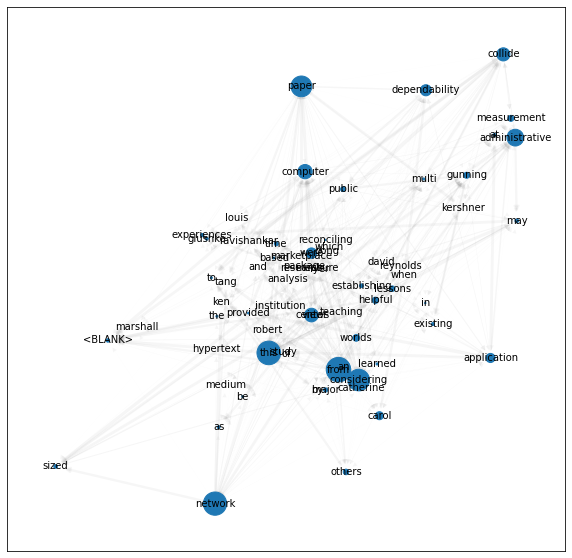

In [80]:
fig = plt.figure(figsize=(10,10))
#pos=nx.spring_layout(G)
#pos=nx.spiral_layout(G)

doc_weigs = np.array(weigths[i,:n,0].tolist())
#doc_weigs /= doc_weigs.max(axis=0)
doc_weigs = (doc_weigs - doc_weigs.min(axis=0)) / (doc_weigs.max(axis=0) - doc_weigs.min(axis=0))

node_sizes  = [ doc_weigs[nid]*600 for nid in G.nodes ]
node_labels = { nid: inv_dict[nid] for nid in G.nodes }
edge_alphas = { nid: 1.-doc_weigs[nid] for nid in G.nodes }
edge_widths = { nid: doc_weigs[nid]*3. for nid in G.nodes }

ax = nx.draw_networkx_nodes(G, pos=pos, node_size=node_sizes)
ax = nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
ax = nx.draw_networkx_edges(G, pos=pos, edge_color='darkgray', width=edge_widths, alpha=0.1)
#for nid, alpha in tqdm(edge_alphas.items(), total=len(edge_alphas)):
#    ax = nx.draw_networkx_edges(G, pos=pos, nodelist=[nid], edge_color='darkgray', width=edge_widths, alpha=alpha)

In [55]:
np.power(doc_weigs, 2).sum(), doc_weigs.sum()

(7.9973053420630045, 10.42282787093708)

In [33]:
doc_weigs, doc_weigs2

NameError: name 'doc_weigs2' is not defined

In [ ]:
G = nx.DiGraph()

In [ ]:
len(sp_matrix.nonzero()[0])

In [ ]:
"""
acm ####################################################################################
Train loss: 1.6009/1.6089 ACC: 0.94886                                                                                                    
Val loss: 1.7718 ACC: 0.77475                                                                                                    
New Best Val loss: 1.7718                                                                                                    
Test loss: 1.7678 ACC: 0.78557  79.92

Train loss: 1.7209/1.6095 ACC: 0.82338                                                                                                    
Val loss: 1.7595 ACC: 0.78236                                                                                                    
New Best Val loss: 1.7595                                                                                             
Test loss: 1.7585 ACC: 0.78557                                                                                                    

20ng ####################################################################################
Train loss: 2.0907/2.0787 ACC: 0.98845                                                                                                    
Val loss: 2.1869 ACC: 0.90803                                                                                                    
New Best Val loss: 2.1869                                                                                                    
Test loss: 2.178 ACC: 0.91068   92.65

Train loss: 2.1603/2.1249 ACC: 0.92511                                                                                                    
Val loss: 2.1842 ACC: 0.90645                                                                                                    
drop: 0.8436
New Best Val loss: 2.1842                                                                                                   
Test loss: 2.1705 ACC: 0.91226                                                                                                    

reut ####################################################################################
Train loss: 3.7735/3.5191 ACC: 0.74734            acm                                                                                        
Val loss: 3.8554 ACC: 0.6763                                                                                                    
New Best Val loss: 3.8554                                                                                                    
Test loss: 3.8493 ACC: 0.6837  72.67

Train loss: 3.7443/3.8521 ACC: 0.77727                                                                                                    
Val loss: 3.808 ACC: 0.71037                                                                                                     
New Best Val loss: 3.808
Test loss: 3.8461 ACC: 0.70444                                                                                                    

webkb ####################################################################################
Train loss: 1.2228/1.2037 ACC: 0.9504                                                                                                     
Val loss: 1.3787 ACC: 0.80316                                                                                                    
New Best Val loss: 1.3787                                                                                                    
Test loss: 1.3857 ACC: 0.78858   81.53

Epoch: 45
Train loss: 1.2392/1.2909 ACC: 0.9295                                                                                                     
Val loss: 1.3838 ACC: 0.78736                                                                                                    
New Best Val loss: 1.3838
Test loss: 1.3814 ACC: 0.78372                                                                                                    

"""

In [ ]:
dt_h = ab.dt_emb( x_packed )
dt_h.shape

In [ ]:
bx_packed = x_packed == 0
doc_sizes = bx_packed.logical_not().sum(dim=1).view(batch_size, 1)
pad_mask  = bx_packed.logical_not()
pad_mask  = pad_mask.view(*bx_packed.shape, 1)
pad_mask  = pad_mask.logical_and(pad_mask.transpose(1, 2))
pad_mask.shape, doc_sizes.shape, bx_packed.shape 

In [ ]:
doc_means = (bx_packed.logical_not().view(*bx_packed.shape, 1) * dt_h).sum(axis=1) / doc_sizes
doc_means = doc_means.view(*doc_means.shape, 1).transpose(1,2)
doc_means.shape

In [ ]:
n_dt_h = dt_h/doc_sizes.view(*doc_sizes.shape, 1)
n_dt_h = (doc_means - n_dt_h)
n_dt_h.shape

In [ ]:
class AttentionBag(nn.Module):
    def __init__(self, vocab_size, hiddens, nclass, drop=.5, initrange=.5):
        super(AttentionBag, self).__init__()
        self.hiddens    = hiddens
        self.mask       = Mask()
        self.dt_emb     = nn.Embedding(vocab_size, hiddens)
        self.tt_emb     = nn.Embedding(vocab_size, hiddens)
        self.tt_dir_map = nn.Linear(hiddens, hiddens)
        self.drop       = nn.Dropout(drop)
        self.ma_term    = nn.MultiheadAttention(hiddens, 1)
        self.fc         = nn.Linear(hiddens, nclass)
        self.initrange  = initrange 
        self.init_weights()
    def forward(self, terms_idx, docs_offsets):
        n = terms_idx.shape[0]
        batch_size = docs_offsets.shape[0]
        
        k         = [ terms_idx[ docs_offsets[i-1]:docs_offsets[i] ] for i in range(1, batch_size) ]
        k.append( terms_idx[ docs_offsets[-1]: ] )
        x_packed  = pad_sequence(k, batch_first=True, padding_value=0)

        bx_packed = x_packed == 0
        pad_mask  = bx_packed.logical_not()
        pad_mask  = pad_mask.view(*bx_packed.shape, 1)
        pad_mask  = pad_mask.logical_and(pad_mask.transpose(1, 2))
        
        dt_h      = self.dt_emb( x_packed )
        dt_h      = self.drop(dt_h)
        tt_h      = self.tt_emb( x_packed )
        dir_tt_h  = self.tt_dir_map( dt_h )

        weights = torch.bmm( tt_h, dir_tt_h.transpose( 1, 2 ) )
        weights = self.mask(weights)
        
        weights_disc = (weights * pad_mask)
        weights_disc = weights_disc.sum(axis=1)
        weights_disc = F.softmax(weights_disc, dim=1)
        weights_disc = weights_disc.view( *weights_disc.shape, 1 )
        
        attn_mask = weights != 0
        attn_mask = attn_mask.logical_and( pad_mask ).logical_not()
        
        dt_h     = dt_h.transpose(0,1)
        dir_dt_h = dir_dt_h.transpose(0,1)
        docs_att, weigths_att = self.ma_term( dt_h, dir_dt_h, dt_h,
                                  key_padding_mask=bx_packed, 
                                  attn_mask=attn_mask )

        weigths_att = torch.where(torch.isnan(weigths_att), torch.zeros_like(weigths_att), weigths_att)
        weigths_att = (weigths_att * pad_mask)
        weigths_att = weigths_att.sum(axis=1)
        weigths_att = F.softmax(weigths_att, dim=1)
        weigths_att = weigths_att.view( *weigths_att.shape, 1 )
        
        weigths = weights_disc + weigths_att

        docs_att = docs_att.transpose(0,1)
        docs_att = torch.where(torch.isnan(docs_att), torch.zeros_like(docs_att), docs_att)
        
        docs_h = docs_att * weigths
        docs_h = docs_h.sum(axis=1)
        docs_h = docs_h / bx_packed.logical_not().sum(dim=1).view(batch_size, 1)
        docs_h = torch.where(torch.isnan(docs_h), torch.zeros_like(docs_h), docs_h)
        docs_h = self.drop(docs_h)
        return self.fc(docs_h)
    
    def init_weights(self):
        self.dt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.dt_dir_map.weight.data.uniform_(-self.initrange, self.initrange)
        self.fc.weight.data.uniform_(-self.initrange, self.initrange)
        self.ma_term.in_proj_weight.data.uniform_(-self.initrange, self.initrange)

In [ ]:
y_pred_t      = pred_docs_t.argmax(axis=1)
correct_t     = (y_pred_t == y_t).sum().item()
total_t       = len(y_t)
correct_t/total_t

In [ ]:
docs_offsets_t

In [ ]:
terms_idx_t[:docs_offsets_t[batch_size]]

In [ ]:
batch_off_test  = docs_offsets_t[batch_size]
batch_tidx_test = terms_idx_t[:batch_off_test]
h_terms_test    = sc.tt_emb( batch_tidx_test )
dirh_terms_test = sc.tt_dir_map( h_terms_test )

W = torch.matmul( h_terms_test, dirh_terms_test.T )
W = F.leaky_relu( W, negative_slope=sc.mask.negative_slope)
W = F.sigmoid(W)
W

In [ ]:
k = [ batch_tidx_test[ docs_offsets_t[i-1]:docs_offsets_t[i] ] for i in range(1, batch_size) ]
k.append( batch_tidx_test[ docs_offsets_t[batch_size-1]:docs_offsets_t[batch_size] ] )
x_packed = pad_sequence(k, batch_first=True, padding_value=0)
tt_emb = sc.tt_emb( x_packed )
len(k)

In [ ]:
x_packed = pad_sequence(k, batch_first=True, padding_value=0)
tt_emb = sc.tt_emb( x_packed )

In [ ]:
tt_emb.transpose(0,1)

In [ ]:
a = [terms_idx, terms_idx]
torch.stack(a)

In [ ]:
F.softmax(pred_docs_t).argmax(axis=1)

In [ ]:
y_val

In [ ]:
(y_t == F.softmax(pred_docs_t).argmax(axis=1)).sum().item()/y_t.shape[0]

In [ ]:
terms_idx_t, docs_offsets_t

In [ ]:
shifts = sc._get_shift_(docs_offsets_t, terms_idx_t.shape[0])

In [ ]:
zipado = zip(docs_offsets_t, shifts)
#next(zipado)
start,size = next(zipado)

In [ ]:
w = sc.tt_emb( terms_idx_t[start:start+size] )
w1 = sc.tt_dir_map( w )
w = torch.matmul( w, w1.T )
w = F.leaky_relu( w, negative_slope=sc.negative_slope)
w = F.sigmoid(w)
#w = F.tanh(w)
#w = F.relu(w)
#w = w.mean(axis=1)
#w = F.softmax(w)
w,w1

In [ ]:
w.round().sum() / (w.shape[0]*w.shape[1])

In [ ]:
inv_mapper = { v:k for (k,v) in tokenizer.node_mapper.items() }

In [ ]:
terms_idx[start:start+size]

In [ ]:
fold.X_val[0]

In [ ]:
bla = w.mean(axis=1)
bla = F.softmax(bla)
#bla = bla/torch.clamp(bla.sum(), 0.0001)
bla

In [ ]:
[ (i, tid.item(),inv_mapper[tid.item()], wei.item()) for i, (tid, wei) in enumerate(zip(terms_idx[start:start+size], bla)) ]

In [ ]:
w

In [ ]:
w.mean(axis=1)

In [ ]:
w.shape

In [ ]:
norm = nn.BatchNorm1d(num_features=1).to(device)

bla2 = norm(bla.view(-1, 1)).squeeze()
bla2 = F.sigmoid(bla2)
bla2

In [ ]:
1

In [ ]:
ma = nn.MultiheadAttention(300, 300).to(device)
ma

In [ ]:
torch.__version__

In [ ]:
a,b = w.shape
w_ = w.view(a,1,b)
w1_ = w1.view(a,1,b)

attn_output = ma(w_, w1_, w_, need_weights=False)

attn_output.view(a,b)
attn_output_weights.view(a,a)

In [ ]:
attn_output.view(a,b).shape

In [ ]:
attn_output_weights.view(a,a)

In [ ]:
F.softmax(torch.Tensor([[0.0718, 0.0716, 0.0712, 0.0714, 0.0721, 0.0710, 0.0712, 0.0714, 0.0710,
         0.0719, 0.0711, 0.0712, 0.0718, 0.0714],
        [0.0722, 0.0709, 0.0710, 0.0709, 0.0728, 0.0723, 0.0709, 0.0709, 0.0719,
         0.0712, 0.0709, 0.0707, 0.0725, 0.0707],
        [0.0711, 0.0715, 0.0710, 0.0713, 0.0710, 0.0712, 0.0718, 0.0713, 0.0709,
         0.0725, 0.0716, 0.0719, 0.0710, 0.0719],
        [0.0721, 0.0717, 0.0714, 0.0713, 0.0717, 0.0714, 0.0711, 0.0710, 0.0713,
         0.0717, 0.0710, 0.0712, 0.0720, 0.0711],
        [0.0722, 0.0711, 0.0710, 0.0710, 0.0737, 0.0716, 0.0709, 0.0705, 0.0714,
         0.0719, 0.0707, 0.0707, 0.0731, 0.0702],
        [0.0714, 0.0716, 0.0708, 0.0711, 0.0718, 0.0713, 0.0712, 0.0717, 0.0712,
         0.0724, 0.0713, 0.0712, 0.0716, 0.0714],
        [0.0712, 0.0714, 0.0713, 0.0713, 0.0722, 0.0716, 0.0709, 0.0714, 0.0714,
         0.0717, 0.0713, 0.0713, 0.0716, 0.0713],
        [0.0716, 0.0707, 0.0712, 0.0714, 0.0717, 0.0715, 0.0714, 0.0715, 0.0712,
         0.0721, 0.0711, 0.0714, 0.0717, 0.0715],
        [0.0717, 0.0713, 0.0708, 0.0710, 0.0725, 0.0717, 0.0714, 0.0709, 0.0712,
         0.0712, 0.0712, 0.0717, 0.0720, 0.0714],
        [0.0709, 0.0712, 0.0713, 0.0712, 0.0713, 0.0713, 0.0714, 0.0719, 0.0712,
         0.0724, 0.0715, 0.0715, 0.0717, 0.0713],
        [0.0715, 0.0716, 0.0712, 0.0708, 0.0725, 0.0717, 0.0712, 0.0714, 0.0714,
         0.0717, 0.0713, 0.0706, 0.0718, 0.0712],
        [0.0726, 0.0711, 0.0713, 0.0706, 0.0737, 0.0721, 0.0709, 0.0707, 0.0714,
         0.0708, 0.0706, 0.0705, 0.0730, 0.0707],
        [0.0718, 0.0711, 0.0714, 0.0715, 0.0725, 0.0707, 0.0707, 0.0711, 0.0712,
         0.0728, 0.0711, 0.0713, 0.0719, 0.0709],
        [0.0712, 0.0716, 0.0713, 0.0712, 0.0717, 0.0707, 0.0708, 0.0721, 0.0709,
         0.0728, 0.0713, 0.0716, 0.0711, 0.0715]]).sum(axis=0))

In [ ]:
class NotTooSimpleClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_l, nclass, dropout1=0.1, dropout2=0.1, negative_slope=99,
                 initrange = 0.5, scale_grad_by_freq=False, device='cuda:0'):
        super(NotTooSimpleClassifier, self).__init__()
        
        self.dt_emb = nn.Embedding(vocab_size, hidden_l, scale_grad_by_freq=scale_grad_by_freq)
        self.tt_emb = nn.Embedding(vocab_size, hidden_l, scale_grad_by_freq=scale_grad_by_freq)
        
        self.undirected_map = nn.Linear(hidden_l, hidden_l)
        
        self.fc = nn.Linear(hidden_l, nclass)
        self.drop1 = nn.Dropout(dropout1)
        self.drop2 = nn.Dropout(dropout2)
        
        self.norm = nn.BatchNorm1d(1)
        
        self.initrange = initrange
        self.nclass = nclass
        self.negative_slope = negative_slope
        
        self.init_weights()
        
        #self.labls_emb = nn.Embedding(graph_builder.n_class, 300)
    
    def forward(self, terms_idxs, docs_offsets):
        n = terms_idxs.shape[0]
        weights = []
        shifts = self._get_shift_(docs_offsets, n)
        
        terms_h1 = self.tt_emb(terms_idxs)
        terms_h1 = self.drop1(terms_h1)
        
        terms_h2 = self.undirected_map( terms_h1 )
        #terms_h2 = self.drop1( terms_h2 )
        for start,size in zip(docs_offsets, shifts):
            w  = terms_h1[start:start+size]
            w1 = terms_h2[start:start+size]
            w = torch.matmul( w, w1.T )
            w = F.leaky_relu( w, negative_slope=self.negative_slope)
            w = F.sigmoid(w-5.5)
            w = w.mean(axis=1)
            w = F.softmax(w)
            #w = w / torch.clamp(w.sum(), 0.0001)
            weights.append( w )
        
        weights = torch.cat(weights)
        #weights = self.norm(weights.view(-1, 1)).squeeze()
        #weights = F.sigmoid(weights)
        
        h_docs  = F.embedding_bag(self.dt_emb.weight, terms_idxs, docs_offsets, per_sample_weights=weights, mode='sum')
        h_docs = self.drop2( h_docs )
        pred_docs = self.fc( h_docs )
        return pred_docs

    def init_weights(self):
        self.dt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        self.tt_emb.weight.data.uniform_(-self.initrange, self.initrange)
        
    def _get_shift_(self, offsets, lenght):
        shifts = offsets[1:] - offsets[:-1]
        last = torch.LongTensor([lenght - offsets[-1]]).to( offsets.device )
        return torch.cat([shifts, last])